# import libraries

In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import re
from galvani import BioLogic

from function import read_mpr

import pymysql
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.widgets import Slider,CheckButtons

from scipy.signal import savgol_filter,find_peaks

from tqdm import tqdm

import time

from impedance.visualization import plot_nyquist
from impedance import preprocessing

from sklearn.cluster import KMeans

%matplotlib notebook
%load_ext autoreload
%autoreload 2

# import raw data to MySQL

## read mpr files to pandas dataframe

### read Formation data

In [2]:
#load data from folder
df_form = read_mpr.mpr_pandas('raw_data/form')

In [3]:
#file fullname
read_mpr.searchmpr('raw_data/form')

['raw_data/form\\Cell001_Form_20uA_25T_30RH_Cycle1to10_01_GEIS_CA1.mpr',
 'raw_data/form\\Cell001_Form_20uA_25T_30RH_Cycle1to10_02_GCPL_CA1.mpr',
 'raw_data/form\\Cell001_Form_20uA_25T_30RH_Cycle1to10_03_GEIS_CA1.mpr',
 'raw_data/form\\Cell001_Form_20uA_25T_30RH_Cycle1to10_04_GCPL_CA1.mpr',
 'raw_data/form\\Cell002_Form_20uA_25T_30RH_Cycle1to10_01_GEIS_CA2.mpr',
 'raw_data/form\\Cell002_Form_20uA_25T_30RH_Cycle1to10_02_GCPL_CA2.mpr',
 'raw_data/form\\Cell002_Form_20uA_25T_30RH_Cycle1to10_03_GEIS_CA2.mpr',
 'raw_data/form\\Cell002_Form_20uA_25T_30RH_Cycle1to10_04_GCPL_CA2.mpr',
 'raw_data/form\\Cell003_Form_50uA_25T_30RH_Cycle1to10_01_GEIS_CA3.mpr',
 'raw_data/form\\Cell003_Form_50uA_25T_30RH_Cycle1to10_02_GCPL_CA3.mpr',
 'raw_data/form\\Cell003_Form_50uA_25T_30RH_Cycle1to10_03_GEIS_CA3.mpr',
 'raw_data/form\\Cell003_Form_50uA_25T_30RH_Cycle1to10_04_GCPL_CA3.mpr',
 'raw_data/form\\Cell004_Form_50uA_25T_30RH_Cycle1to10_01_GEIS_CA4.mpr',
 'raw_data/form\\Cell004_Form_50uA_25T_30RH_Cycle1t

In [4]:
#cpl
df_form[0]

,freq/Hz,Re(Z)/Ohm,-Im(Z)/Ohm,|Z|/Ohm,Phase(Z)/deg,time/s,Ewe/V,I/mA,Cs/µF,Cp/µF,cycle number,|Ewe|/V,|I|/A,I Range,loop_Nr,cycle_Nr
0,10001.000000,20.116896,672.406189,672.707031,-88.286346,6.338000e+00,0.004219,-0.001763,0.023667,0.023646,0.0,0.003154,0.000005,117,0,1
1,6740.000000,576.129150,936.676025,1099.675781,-58.405228,1.260800e+01,0.003156,-0.003312,0.025210,0.018290,0.0,0.005320,0.000005,117,0,1
2,4541.999512,780.680786,1205.806519,1436.465088,-57.079586,1.887400e+01,0.009140,0.000473,0.029060,0.020477,0.0,0.007004,0.000005,117,0,1
3,3061.000977,1052.983398,1524.199707,1852.554688,-55.361599,2.513600e+01,0.007566,-0.002180,0.034113,0.023092,0.0,0.009089,0.000005,117,0,1
4,2063.000488,1414.236328,1897.714111,2366.724121,-53.305363,3.139800e+01,0.012290,0.000498,0.040653,0.026137,0.0,0.011646,0.000005,117,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.048894,964.120178,239.924622,993.524780,-13.974398,2.122496e+06,0.012290,0.000492,13567.063477,791.185120,0.0,0.004688,0.000005,117,9,10
356,0.032596,1017.525024,265.055298,1051.480591,-14.600521,2.122649e+06,0.012566,0.000654,18421.095703,1170.539062,0.0,0.004980,0.000005,117,9,10
357,0.020955,1071.146484,302.079987,1112.927246,-15.749279,2.122877e+06,0.015637,0.004697,25142.910156,1852.362183,0.0,0.005233,0.000005,117,9,10
358,0.013970,1153.004761,340.049652,1202.103882,-16.432093,2.123213e+06,0.007526,-0.001604,33503.210938,2680.939941,0.0,0.005696,0.000005,117,9,10


In [5]:
#eis
df_form[1]

,flags,Ns,time/s,dQ/mA.h,(Q-Qo)/mA.h,control/V/mA,Ewe/V,I Range,Q charge/discharge/mA.h,half cycle,loop_Nr,cycle_Nr
0,15,0,1.680460e+03,-3.409833e-10,-3.409833e-10,0.00,-0.161267,115,-3.409833e-10,0,0,1
1,15,0,1.685460e+03,0.000000e+00,-3.409833e-10,0.00,-0.161267,115,-3.409833e-10,0,0,1
2,31,0,1.690486e+03,0.000000e+00,-3.409833e-10,0.02,0.173130,117,-3.409833e-10,0,0,1
3,53,1,1.690488e+03,1.106957e-08,1.072859e-08,0.02,0.184352,117,1.072859e-08,0,0,1
4,21,1,1.695488e+03,2.772917e-05,2.773990e-05,0.02,0.867360,117,2.773990e-05,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
189758,23,1,2.191576e+06,0.000000e+00,2.462457e-01,0.00,2.056041,115,4.008953e+00,0,9,10
189759,23,1,2.191581e+06,0.000000e+00,2.462457e-01,0.00,2.056041,115,4.008953e+00,0,9,10
189760,23,1,2.191586e+06,0.000000e+00,2.462457e-01,0.00,2.056119,115,4.008953e+00,0,9,10
189761,23,1,2.191591e+06,0.000000e+00,2.462457e-01,0.00,2.055962,115,4.008953e+00,0,9,10


#### add serval columns

In [6]:
# list paths of data in .mpr file
datafilespath = glob('raw_data/form/*.mpr')
datafilespath =  [os.path.basename(x) for x in datafilespath]

In [37]:
datafilespath

['Cell001_Form_20uA_25T_30RH_Cycle1to10_01_GEIS_CA1.mpr',
 'Cell001_Form_20uA_25T_30RH_Cycle1to10_02_GCPL_CA1.mpr',
 'Cell001_Form_20uA_25T_30RH_Cycle1to10_03_GEIS_CA1.mpr',
 'Cell001_Form_20uA_25T_30RH_Cycle1to10_04_GCPL_CA1.mpr',
 'Cell002_Form_20uA_25T_30RH_Cycle1to10_01_GEIS_CA2.mpr',
 'Cell002_Form_20uA_25T_30RH_Cycle1to10_02_GCPL_CA2.mpr',
 'Cell002_Form_20uA_25T_30RH_Cycle1to10_03_GEIS_CA2.mpr',
 'Cell002_Form_20uA_25T_30RH_Cycle1to10_04_GCPL_CA2.mpr',
 'Cell003_Form_50uA_25T_30RH_Cycle1to10_01_GEIS_CA3.mpr',
 'Cell003_Form_50uA_25T_30RH_Cycle1to10_02_GCPL_CA3.mpr',
 'Cell003_Form_50uA_25T_30RH_Cycle1to10_03_GEIS_CA3.mpr',
 'Cell003_Form_50uA_25T_30RH_Cycle1to10_04_GCPL_CA3.mpr',
 'Cell004_Form_50uA_25T_30RH_Cycle1to10_01_GEIS_CA4.mpr',
 'Cell004_Form_50uA_25T_30RH_Cycle1to10_02_GCPL_CA4.mpr',
 'Cell004_Form_50uA_25T_30RH_Cycle1to10_03_GEIS_CA4.mpr',
 'Cell004_Form_50uA_25T_30RH_Cycle1to10_04_GCPL_CA4.mpr',
 'Cell005_Form_100uA_25T_30RH_Cycle1to10_01_GEIS_CA5.mpr',
 'Cell005_For

##### half cycle and state of charge

In [38]:
#set half cycle of discharge processes to 1 in gcpl
#ds[3,7,11...]
discharge_index = np.arange(3,np.shape(datafilespath)[0],4)
for index in discharge_index:
    df_form[index]['half cycle']=1
#set state of charge in geis
cell_empty_index = np.arange(0,np.shape(datafilespath)[0],4)
cell_full_index = np.arange(2,np.shape(datafilespath)[0],4)
for index in cell_empty_index:
    df_form[index]['state of charge']=0
for index in cell_full_index:
    df_form[index]['state of charge']=1

In [39]:
discharge_index = np.arange(3,np.shape(datafilespath)[0],4)
discharge_index

array([ 3,  7, 11, 15, 19, 23, 27, 31])

### read Cycling data

In [29]:
df_cycle = read_mpr.mpr_pandas('raw_data/cycle_new')

In [45]:
df_cycle[13]

,flags,Ns,time/s,dQ/mA.h,(Q-Qo)/mA.h,control/V/mA,Ewe/V,I Range,Q charge/discharge/mA.h,half cycle,loop_Nr,cycle_Nr
0,7,0,1.130115e+04,-1.589131e-10,-1.589131e-10,0.0,0.178585,115,-1.589131e-10,0,0,11
1,7,0,1.130615e+04,0.000000e+00,-1.589131e-10,0.0,0.185987,115,-1.589131e-10,0,0,11
2,23,0,1.131123e+04,0.000000e+00,-1.589131e-10,0.2,0.559663,116,-1.589131e-10,0,0,11
3,53,1,1.131123e+04,1.107981e-07,1.106391e-07,0.2,0.568639,116,1.106391e-07,0,0,11
4,21,1,1.131623e+04,2.774219e-04,2.775325e-04,0.2,1.135787,116,2.775325e-04,0,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...
1493747,7,2,7.709489e+06,0.000000e+00,-3.009070e-03,0.0,0.003106,115,-1.021817e-01,1,7,98
1493748,7,2,7.709494e+06,0.000000e+00,-3.009070e-03,0.0,0.003067,115,-1.021817e-01,1,7,98
1493749,7,2,7.709499e+06,0.000000e+00,-3.009070e-03,0.0,0.003106,115,-1.021817e-01,1,7,98
1493750,7,2,7.709504e+06,0.000000e+00,-3.009070e-03,0.0,0.003067,115,-1.021817e-01,1,7,98


In [11]:
# sometimes the error appears
cyc_files = glob('raw_data/cycle/*.mpr')
for file in cyc_files:
    try:
        BioLogic.MPRfile(file)
    except:
        print('files: '+file+' is unreadable')

similar issue: https://github.com/echemdata/galvani/issues/39

# import dataframes to Mysql

## Structure 1(deprecated):    
cell001:     
-step01_geis    
-step02_gcpl    
-step03_geis    
-step04_gcpl    

```python

##structure 1
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword)
print('connection succeed')


cursor = Connection.cursor()
cursor.execute('DROP DATABASE IF EXISTS cell_configuration;')
cursor.execute('CREATE DATABASE cell_configuration;')

##cell configuration
engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db='cell_configuration', user=dbuser, pw=dbpassword))
read_mpr.filename_read(datafilespath).to_sql('cell_configuration', engine, if_exists='fail',index=False)
print('table cell_configuration created')

Cell_ID = np.unique([x.split('_')[0] for x in datafilespath])
Unique_Index = np.append(np.unique([x.split('_')[0] for x in datafilespath],return_index=True)[1],len(df_form))
Tech_Type = [x.split('_')[-2].lower() for x in datafilespath]

##labor data
for i in range(len(Cell_ID)):
    cursor.execute('DROP DATABASE IF EXISTS '+Cell_ID[i])
    cursor.execute('CREATE DATABASE '+Cell_ID[i])
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=Cell_ID[i], user=dbuser, pw=dbpassword))
    step_ID = [x.split('_')[-3] for x in datafilespath]
    # capacity
    
    for j in range(Unique_Index[i],Unique_Index[i+1]):
        if step_ID[j]=='02':
            df_form[j].to_sql('step'+step_ID[j]+'_'+'charge', engine, if_exists='fail',index=False)
        elif step_ID[j]=='04':
            df_form[j].to_sql('step'+step_ID[j]+'_'+'discharge', engine, if_exists='fail',index=False)
        else:
            df_form[j].to_sql('step'+step_ID[j]+'_'+Tech_Type[j], engine, if_exists='fail',index=False)
            
        print('table '+'step'+step_ID[j]+'_'+Tech_Type[j]+' of '+Cell_ID[i]+' created')
        
print('All data loaded')
```

## Structure 2:    
cell001:    
-geis    
-gcpl    

In [12]:
#structure 2
#We prefer this structure!
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword)
print('connection succeed')


cursor = Connection.cursor()
cursor.execute('DROP DATABASE IF EXISTS cell_configuration;')
cursor.execute('CREATE DATABASE cell_configuration;')

##cell configuration
datafilespath_form = glob('raw_data/form/*.mpr')
datafilespath_form = [os.path.basename(x) for x in datafilespath_form]
datafilespath_cyc = glob('raw_data/cycle/*.mpr')
datafilespath_cyc = [os.path.basename(x) for x in datafilespath_cyc]
datafilespath = np.append(datafilespath_form,datafilespath_cyc)
engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db='cell_configuration', user=dbuser, pw=dbpassword))
read_mpr.filename_read(datafilespath).to_sql('cell_configuration', engine, if_exists='fail',index=False)
print('table cell_configuration created')


##formation labor data
Cell_ID = np.unique([x.split('_')[0] for x in datafilespath_form])#[cell001,cell002...]
Unique_Index = np.append(np.unique([x.split('_')[0] for x in datafilespath_form],return_index=True)[1],len(df_form))
Tech_Type = [x.split('_')[-2].lower() for x in datafilespath_form]
print('='*100+'\nForm data:')
form_start_time = time.time()
chunksize = 5000
for i in range(len(Cell_ID)):
    cursor.execute('DROP DATABASE IF EXISTS '+Cell_ID[i])
    cursor.execute('CREATE DATABASE '+Cell_ID[i])
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=Cell_ID[i], user=dbuser, pw=dbpassword))
    step_ID = [x.split('_')[-3] for x in datafilespath_form]
    
    geis_data_index=[]
    for j in range(Unique_Index[i],Unique_Index[i+1]):
        if j in np.where(np.array(Tech_Type)== 'geis')[0]:
            geis_data_index = np.append(geis_data_index,j)
    geis_data = pd.concat([df_form[int(k)] for k in geis_data_index],ignore_index=True)
    geis_data=geis_data.sort_values(by=['time/s'])
    geis_data.to_sql('form_geis', engine, if_exists='fail',index=False,chunksize = chunksize)
    print('geis data of '+Cell_ID[i]+ ' uploaded')
    
    gcpl_data_index=[]
    for j in range(Unique_Index[i],Unique_Index[i+1]):
        
        if j in np.where(np.array(Tech_Type)== 'gcpl')[0]:
            gcpl_data_index = np.append(gcpl_data_index,j)
    gcpl_data = pd.concat([df_form[int(k)] for k in gcpl_data_index],ignore_index=True)
    gcpl_data=gcpl_data.sort_values(by=['time/s'])
    gcpl_data.to_sql('form_gcpl', engine, if_exists='fail',index=False,chunksize = chunksize)    
    print('gcpl data of '+Cell_ID[i]+ ' uploaded')    

form_end_time = time.time()
print('formation data processing time: ', form_end_time - form_start_time,'s')
print('='*100+'\nCycle data:')
##cycling labor data   
db=np.unique([x.split('_')[0] for x in datafilespath_cyc])
cyc_start_time = time.time()
for cell,index in zip(db,range(0,16,2)):
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)   
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
    df_cycle[index].to_sql('cyc_geis', engine, if_exists='replace',index=False,chunksize = chunksize)
    print('geis data of '+cell+ ' uploaded')
    df_cycle[index+1].to_sql('cyc_gcpl', engine, if_exists='replace',index=False,chunksize = chunksize)
    print('gcpl data of '+cell+ ' uploaded')
    
print('='*100)
print('All data uploaded')

cyc_end_time = time.time()

print('cycling data processing time: ', cyc_end_time - cyc_start_time,'s')


connection succeed
table cell_configuration created
Form data:
geis data of Cell001 uploaded
gcpl data of Cell001 uploaded
geis data of Cell002 uploaded
gcpl data of Cell002 uploaded
geis data of Cell003 uploaded
gcpl data of Cell003 uploaded
geis data of Cell004 uploaded
gcpl data of Cell004 uploaded
geis data of Cell005 uploaded
gcpl data of Cell005 uploaded
geis data of Cell006 uploaded
gcpl data of Cell006 uploaded
geis data of Cell007 uploaded
gcpl data of Cell007 uploaded
geis data of Cell008 uploaded
gcpl data of Cell008 uploaded
formation data processing time:  738.100781917572 s
Cycle data:
geis data of Cell001 uploaded
gcpl data of Cell001 uploaded
geis data of Cell002 uploaded
gcpl data of Cell002 uploaded
geis data of Cell003 uploaded
gcpl data of Cell003 uploaded
geis data of Cell004 uploaded
gcpl data of Cell004 uploaded
geis data of Cell005 uploaded
gcpl data of Cell005 uploaded
geis data of Cell006 uploaded
gcpl data of Cell006 uploaded
geis data of Cell007 uploaded
gcp

without chunksize:    
    formation data processing time:  249.83825254440308 s    
    cycling data processing time:  1045.3779447078705 s
   
chunksize = 50000(best one!)   
    formation data processing time:  184.6444227695465 s    
    cycling data processing time:  921.2041549682617 s

chunksize = 5000    
    formation data processing time:  212.5893361568451 s    
    cycling data processing time:  1058.742508172989 s
    
chunksize = 10000   
    formation data processing time:  214.2786316871643 s    
    cycling data processing time:  1023.5620315074921 s

chunksize = 30000   
    formation data processing time:  215.41345477104187 s    
    cycling data processing time:  1060.0271468162537 s


# Savitzky-Golay filter

## charge/discharge curve

In [2]:
# query data from MySQL
##cell001, gcpl, structure 2
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db='cell001'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword,
                          database=db)

# structue 2
sql = 'SELECT `(Q-Qo)/mA.h`,`Ewe/V`, `time/s` FROM form_gcpl WHERE loop_Nr=0'
cursor = Connection.cursor()
cursor.execute(sql)
curve = cursor.fetchall()
curve = np.array(curve)

<IPython.core.display.Javascript object>


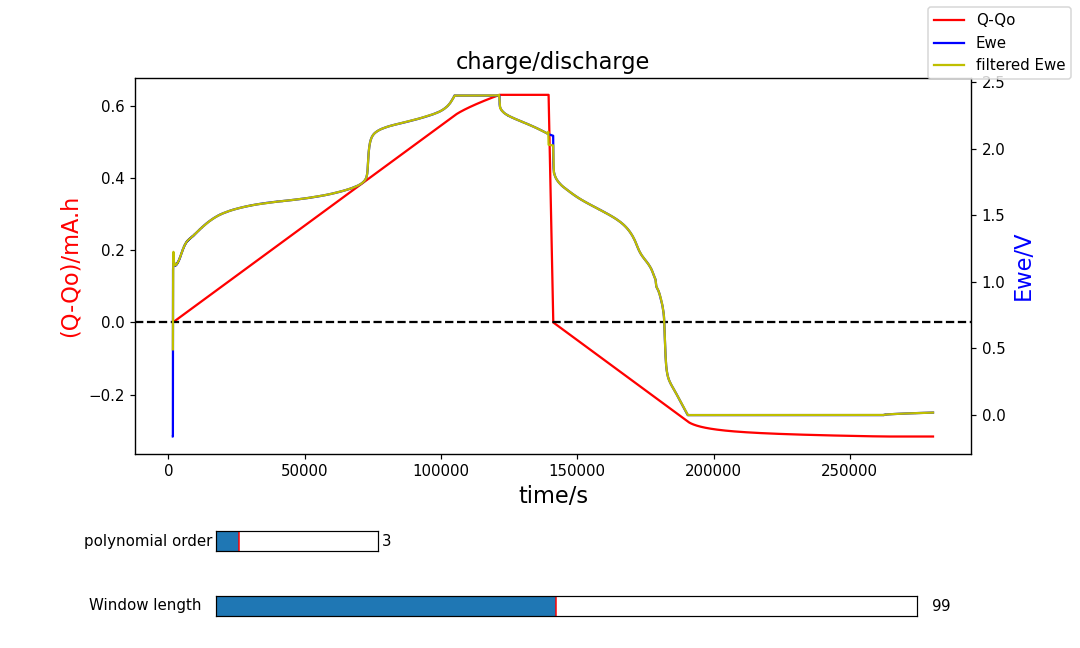

In [3]:
%matplotlib notebook
## plot curves
fig,ax = plt.subplots(figsize=(10,6))
plt.subplots_adjust(bottom=0.3)
ax.set_title('charge/discharge',fontsize=15)
ax.plot(curve[:,2], curve[:,0], color="red",label='Q-Qo')
ax.axhline(0,color='black',linestyle='--')
ax.set_xlabel("time/s",fontsize=15)
ax.set_ylabel("(Q-Qo)/mA.h",color="red",fontsize=15)

ax2=ax.twinx()
ax2.plot(curve[:,2], curve[:,1],"b-",label='Ewe')
ax2.set_ylabel("Ewe/V",color="blue",fontsize=15)


p, = ax2.plot(curve[:,2], savgol_filter(curve[:,1],111,3), "y",label='filtered Ewe')

fig.legend()
## define the slides
ax_slide1 = plt.axes([0.2,0.05,0.65,0.03])
ax_slide2 = plt.axes([0.2,0.15,0.15,0.03])

## properties of slides
win_len = Slider(ax_slide1,'Window length', valmin = 5,valmax = 199,valinit = 99,valstep = 2)
p_order = Slider(ax_slide2,'polynomial order', valmin = 2,valmax = 9,valinit = 3,valstep = 1)

## updating function
def update(val):
    current_win_len = int(win_len.val)
    current_p_order = int(p_order.val)
    p.set_ydata(savgol_filter(curve[:,1],current_win_len,current_p_order))
    fig.canvas.draw()
    
win_len.on_changed(update)
p_order.on_changed(update)

plt.show()


<IPython.core.display.Javascript object>


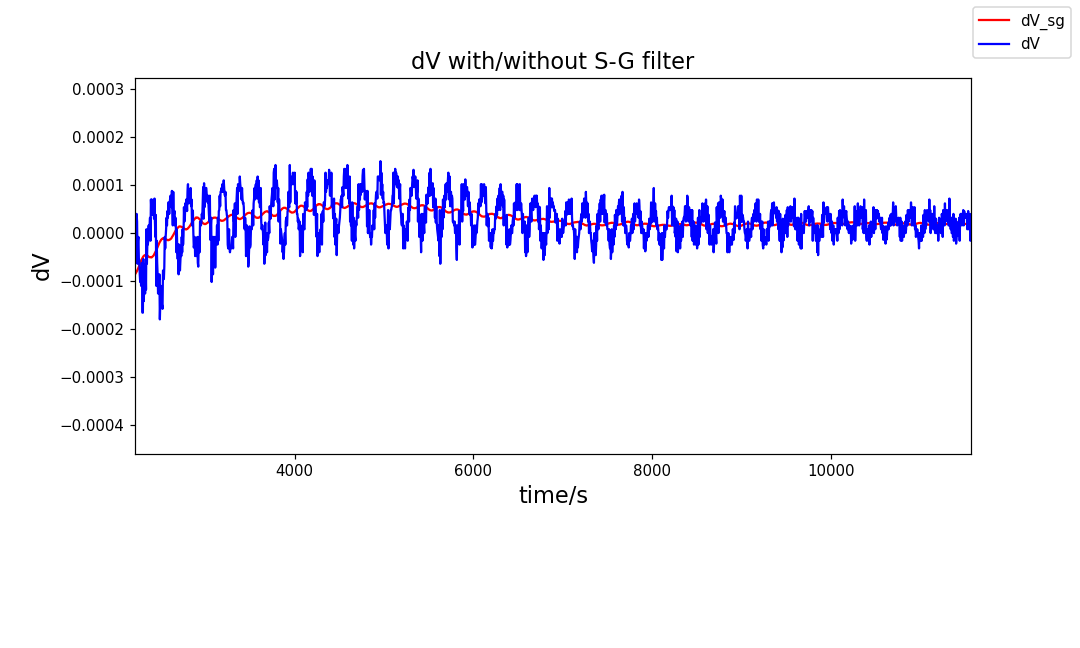

In [110]:
sql = 'SELECT dV,dV_sg,t FROM derivative_of_v_to_time_form WHERE loop_Nr=0'
cellx_df = pd.read_sql(sql, Connection)
%matplotlib notebook
## plot curves
fig,ax = plt.subplots(figsize=(10,6))
plt.subplots_adjust(bottom=0.3)
ax.set_title('dV with/without S-G filter',fontsize=15)
ax.plot( cellx_df['t'],cellx_df['dV_sg'], color="red",label='dV_sg')
ax.set_xlabel("time/s",fontsize=15)
ax.set_ylabel("dV",fontsize=15)

ax.plot(cellx_df['t'],cellx_df['dV'], "b-",label='dV')



fig.legend()


plt.show()


# cell capacity
create a table of each cell to discribe its capacity in all loops

In [15]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db=np.unique([x.split('_')[0] for x in datafilespath])

for cell in db:
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)
    #formation
    sql = 'SELECT `(Q-Qo)/mA.h`,`cycle_Nr`, `half cycle` FROM ' +cell+ '.form_gcpl'
    cellx_df = pd.read_sql(sql, Connection)
    cycle_Nr = np.unique(cellx_df['cycle_Nr'])
    charge=[]
    discharge=[]
    for cycle in cycle_Nr:
        charge.append(cellx_df[(cellx_df['cycle_Nr']==cycle) & (cellx_df['half cycle']==0)]['(Q-Qo)/mA.h'].max())
        discharge.append(cellx_df[(cellx_df['cycle_Nr']==cycle) & (cellx_df['half cycle']==1)]['(Q-Qo)/mA.h'].min())
    capacity_form = {'cycle_Nr':cycle_Nr,'Q_charge':charge,'Q_discharge':discharge,'CE/%':np.round(np.divide(np.abs(discharge),charge)*100,2)}
    capacity_form['cycle type'] = 'Formation'
    capacity_form = pd.DataFrame(data=capacity_form)


    
    #cycling
    sql = 'SELECT `Q charge/discharge/mA.h`,`cycle_Nr`, `half cycle` FROM ' +cell+ '.cyc_gcpl'
    cellx_df = pd.read_sql(sql, Connection)
    cycle_Nr = np.unique(cellx_df['cycle_Nr'])
    charge=[]
    discharge=[]
    for cycle in cycle_Nr:
        charge.append(cellx_df[(cellx_df['cycle_Nr']==cycle) & (cellx_df['half cycle']==0)]['Q charge/discharge/mA.h'].max())
        discharge.append(cellx_df[(cellx_df['cycle_Nr']==cycle) & (cellx_df['half cycle']==1)]['Q charge/discharge/mA.h'].min())
    capacity_cycle = {'cycle_Nr':cycle_Nr,'Q_charge':charge,'Q_discharge':discharge,'CE/%':np.round(np.divide(np.abs(discharge),charge)*100,2)}
    capacity_cycle['cycle type'] = 'Cycling'
    capacity_cycle = pd.DataFrame(data=capacity_cycle,index=cycle_Nr)
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
    
    capacity = pd.concat([capacity_form,capacity_cycle])
    capacity.to_sql('capacity', engine, if_exists='replace',index=False)
    print('table capacity of '+cell +' created')

table capacity of Cell001 created
table capacity of Cell002 created
table capacity of Cell003 created
table capacity of Cell004 created
table capacity of Cell005 created
table capacity of Cell006 created
table capacity of Cell007 created
table capacity of Cell008 created


In [24]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
cell='cell001'
Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)
sql = 'SELECT `CE/%` FROM capacity'
CE = pd.read_sql(sql, Connection)
Connection.close()

<IPython.core.display.Javascript object>


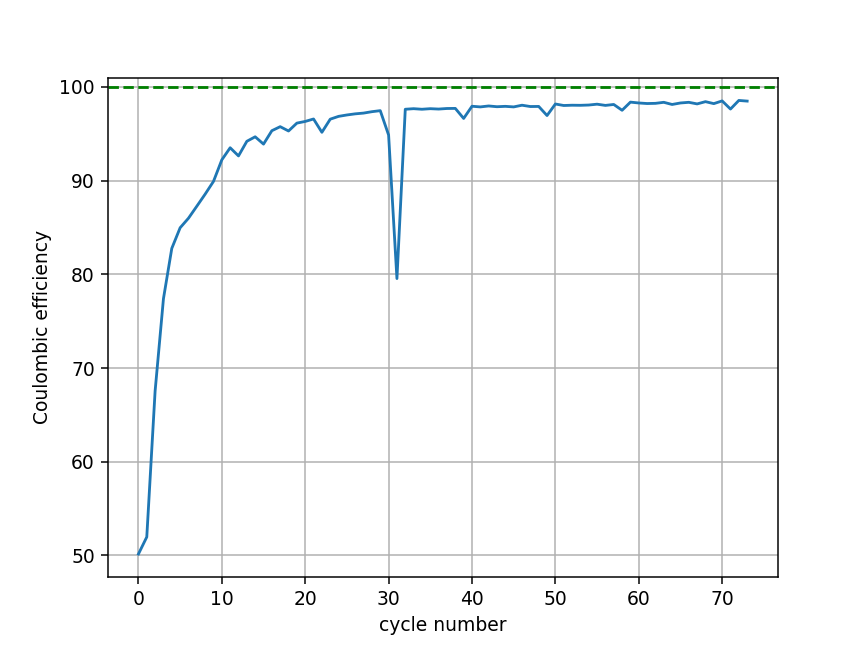

In [25]:
#diagramm of CE
fig,ax = plt.subplots()
CE[CE['CE/%']<50]=np.nan
ax.plot(CE)
ax.axhline(100,color='green',linestyle='--')
ax.set_xlabel('cycle number')
ax.set_ylabel('Coulombic efficiency')

ax.grid()
plt.show()


why somtimes CE > 100%    
explain in:https://www.researchgate.net/post/In_battery_tests_is_coulombic_efficiency_over_100_have_a_particular_meaning

# Fix error in cycling data 

## check the abnormal parts

In [111]:
# query data from MySQL
##cell001, gcpl, structure 2
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db='cell001'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword,
                          database=db)
# structue 2
sql = 'SELECT `Q charge/discharge/mA.h`,`Ewe/V`, `time/s`,`cycle_Nr` FROM cyc_gcpl'
print('data queried')
cell_df = pd.read_sql(sql,Connection)

data queried


<IPython.core.display.Javascript object>


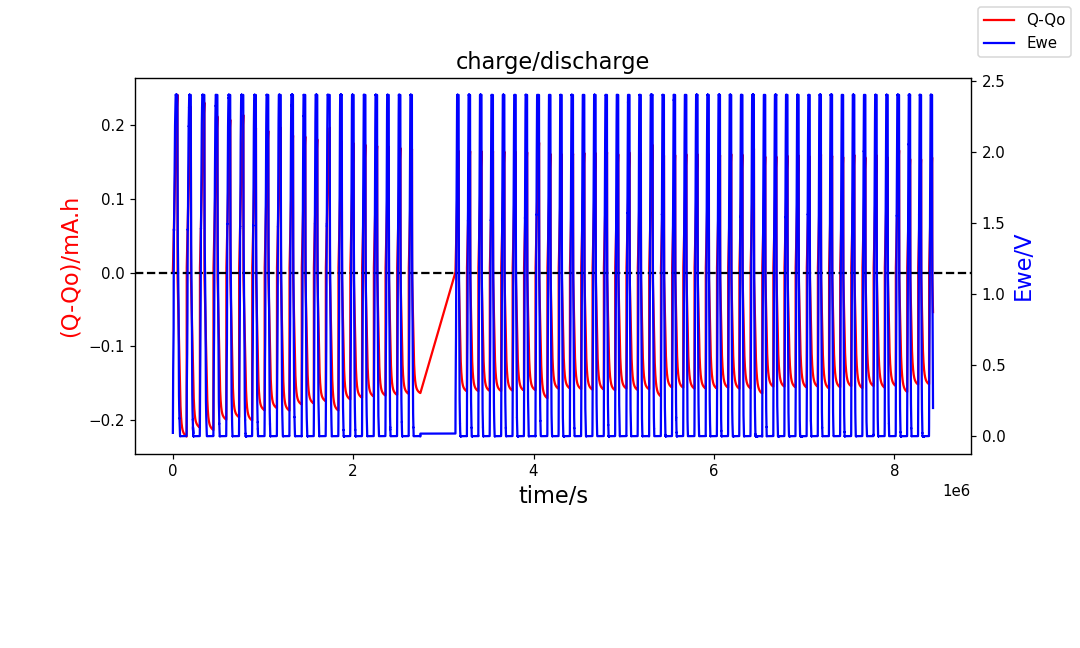

In [114]:
# curve=np.concatenate((charge,discharge))
# curve=curve[curve[:, 2].argsort()]
%matplotlib notebook
## plot curves
fig,ax = plt.subplots(figsize=(10,6))
plt.subplots_adjust(bottom=0.3)
ax.set_title('charge/discharge',fontsize=15)
ax.plot(cell_df['time/s'], cell_df['Q charge/discharge/mA.h'], color="red",label='Q-Qo')
ax.axhline(0,color='black',linestyle='--')
ax.set_xlabel("time/s",fontsize=15)
ax.set_ylabel("(Q-Qo)/mA.h",color="red",fontsize=15)

ax2=ax.twinx()
ax2.plot(cell_df['time/s'], cell_df['Ewe/V'],"b-",label='Ewe')
ax2.set_ylabel("Ewe/V",color="blue",fontsize=15)
fig.legend()



plt.show()


<IPython.core.display.Javascript object>


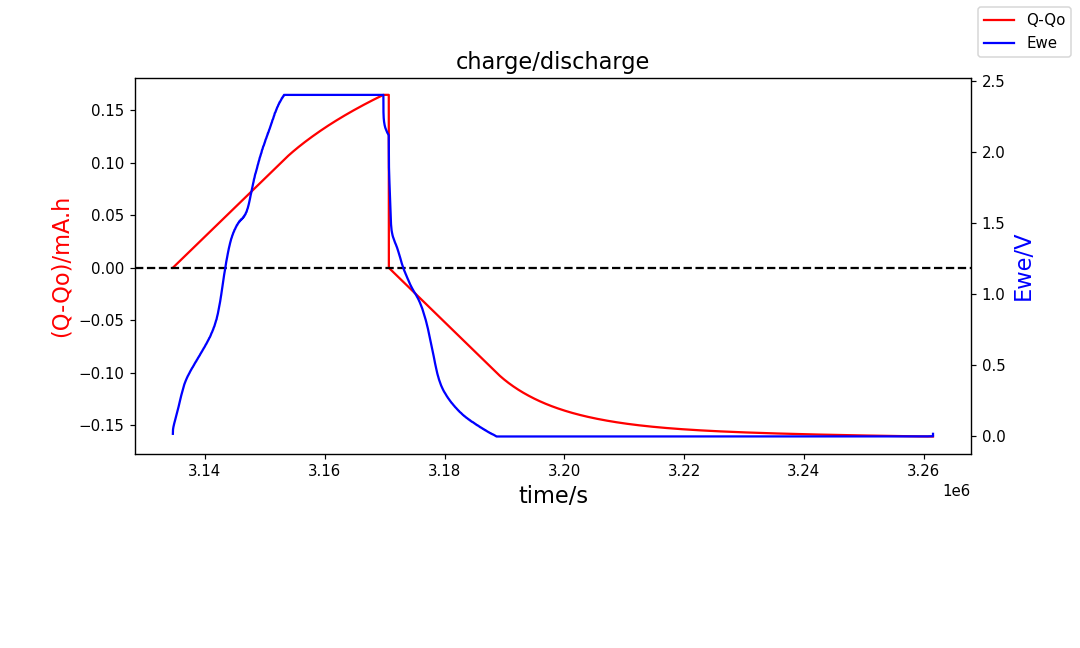

In [113]:
# curve=np.concatenate((charge,discharge))
# curve=curve[curve[:, 2].argsort()]
%matplotlib notebook
## plot curves
fig,ax = plt.subplots(figsize=(10,6))
plt.subplots_adjust(bottom=0.3)
ax.set_title('charge/discharge',fontsize=15)
error_index = np.isin(cell_df['cycle_Nr'],[31,32,33])
ax.plot(cell_df['time/s'][error_index], cell_df['Q charge/discharge/mA.h'][error_index], color="red",label='Q-Qo')
ax.axhline(0,color='black',linestyle='--')
ax.set_xlabel("time/s",fontsize=15)
ax.set_ylabel("(Q-Qo)/mA.h",color="red",fontsize=15)

#vertical lines to distinguish different cycle
time_31_32 = cell_df['time/s'][cell_df['cycle_Nr']==31].max()
time_32_33 = cell_df['time/s'][cell_df['cycle_Nr']==32].max()
ax.axvline(time_31_32,color='green',linestyle='--')
ax.axvline(time_32_33,color='green',linestyle='--')

ax2=ax.twinx()
ax2.plot(cell_df['time/s'][error_index], cell_df['Ewe/V'][error_index],"b-",label='Ewe')
ax2.set_ylabel("Ewe/V",color="blue",fontsize=15)

fig.legend()



plt.show()


The whole cycle 32 looks weird.

In [20]:
t_30 = cell_df['time/s'][cell_df['cycle_Nr']==30].max() - cell_df['time/s'][cell_df['cycle_Nr']==30].min()
t_31 = cell_df['time/s'][cell_df['cycle_Nr']==31].max() - cell_df['time/s'][cell_df['cycle_Nr']==31].min()
t_32 = cell_df['time/s'][cell_df['cycle_Nr']==32].max() - cell_df['time/s'][cell_df['cycle_Nr']==32].min()
t_33 = cell_df['time/s'][cell_df['cycle_Nr']==33].max() - cell_df['time/s'][cell_df['cycle_Nr']==33].min()
t_34 = cell_df['time/s'][cell_df['cycle_Nr']==34].max() - cell_df['time/s'][cell_df['cycle_Nr']==34].min()
print('time of cycle 30: '+str(round(t_30))+'s')
print('time of cycle 31: '+str(round(t_31))+'s')
print('time of cycle 32: '+str(round(t_32))+'s')
print('time of cycle 33: '+str(round(t_33))+'s')
print('time of cycle 34: '+str(round(t_34))+'s')

time of cycle 30: 126712s
time of cycle 31: 134575s
time of cycle 32: 371635s
time of cycle 33: 123779s
time of cycle 34: 123951s


## find the cycle number

In [21]:
def find_error_cycle_numbers(cell_df):
    cycle_numbers = []
    for i in  tqdm(range(1, len(cell_df['time/s']))):
        if cell_df['time/s'][i]-cell_df['time/s'][i-1]>10000:
            return [cell_df['cycle_Nr'][i-1],cell_df['cycle_Nr'][i]]
    

In [22]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
cells=['cell001','cell002','cell003','cell004','cell005','cell006','cell007','cell008']

cyc = []
for cell in cells:
    Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword,
                          database=cell)

    sql = 'SELECT `Q charge/discharge/mA.h`,`Ewe/V`, `time/s`,`cycle_Nr` FROM cyc_gcpl'
    print(cell,' data queried')
    cell_df = pd.read_sql(sql,Connection)
    cyc.append(find_error_cycle_numbers(cell_df))
cyc

cell001  data queried


 35%|████████████████████████                                             | 570958/1640064 [00:05<00:09, 112968.35it/s]


cell002  data queried


 35%|████████████████████████                                             | 570619/1639747 [00:04<00:09, 114944.79it/s]


cell003  data queried


 35%|████████████████████████                                             | 570383/1639336 [00:04<00:09, 117345.01it/s]


cell004  data queried


 35%|████████████████████████▏                                            | 570039/1624061 [00:04<00:08, 118493.94it/s]


cell005  data queried


 36%|████████████████████████▉                                            | 569400/1573494 [00:04<00:08, 118162.37it/s]


cell006  data queried


 38%|██████████████████████████                                           | 569073/1504412 [00:04<00:08, 116598.19it/s]


cell007  data queried


 38%|██████████████████████████▎                                          | 568751/1493751 [00:04<00:07, 120070.05it/s]


cell008  data queried


 38%|█████████████████████████▉                                           | 568400/1509068 [00:04<00:07, 120176.75it/s]


[[31, 32],
 [32, 32],
 [39, 40],
 [39, 40],
 [41, 42],
 [43, 43],
 [43, 44],
 [43, 43]]

## remove these cycles

In [23]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
cells = ['cell001','cell002','cell003','cell004','cell005','cell006','cell007','cell008']

for cycles,cell in  zip(cyc,cells):
    Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword,
                          database=cell)
    cycles = np.unique(cycles)
    if len (cycles) == 1:
        sql = 'DELETE FROM cyc_gcpl WHERE cycle_Nr={}'.format(cycles[0])
    else:
        sql = 'DELETE FROM cyc_gcpl WHERE cycle_Nr={} or cycle_Nr={}'.format(cycles[0],cycles[1])
    cursor = Connection.cursor()
    cursor.execute(sql)
    Connection.commit()
    print('deleted from {}'.format(cell))

deleted from cell001
deleted from cell002
deleted from cell003
deleted from cell004
deleted from cell005
deleted from cell006
deleted from cell007
deleted from cell008


# Voltage and Time

## Formation Phase

In [24]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db=np.unique([x.split('_')[0] for x in datafilespath])
v_dV_ddV_time=[]
for cell in db:
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)

    sql = 'SELECT `Ewe/V`,`time/s`,`half cycle`,`loop_Nr` FROM ' +cell+ '.form_gcpl'
    cellx_df = pd.read_sql(sql, Connection)

    V = cellx_df['Ewe/V']
    #savgol_filter
    win_len = 179
    p_order = 3
    V_sg = savgol_filter(V,win_len,p_order)
    
    t =cellx_df['time/s']
    half_cycle = cellx_df['half cycle']
    loop_Nr = cellx_df['loop_Nr']
    
    #with savgol_filter
    dV_sg = np.divide(np.diff(V_sg,append=-1),np.diff(t,append=-1))
    #without savgpl_filter
    dV = np.divide(np.diff(V,append=-1),np.diff(t,append=-1))
    #2th derivative
    ddV = np.divide(np.diff(savgol_filter(dV_sg,win_len,p_order),append=-1),np.diff(t,append=-1))
    
    derivative_of_v_to_time = {'V':V,'V_sg':V_sg,'dV':dV,'dV_sg':dV_sg,'ddV':ddV,'t':t,'half cycle':half_cycle,'loop_Nr':loop_Nr}
    derivative_of_v_to_time = pd.DataFrame(data=derivative_of_v_to_time)    
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
    derivative_of_v_to_time.to_sql('derivative_of_v_to_time_form', engine, if_exists='replace',index=False,chunksize = 50000)
    print('table derivative_of_v_to_time of '+cell +' created')

table derivative_of_v_to_time of Cell001 created
table derivative_of_v_to_time of Cell002 created
table derivative_of_v_to_time of Cell003 created
table derivative_of_v_to_time of Cell004 created
table derivative_of_v_to_time of Cell005 created
table derivative_of_v_to_time of Cell006 created
table derivative_of_v_to_time of Cell007 created
table derivative_of_v_to_time of Cell008 created


In [7]:
# connection
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
cell='cell001'
Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)

# query from Mysql
sql = 'SELECT * FROM ' +cell+ '.derivative_of_v_to_time_form'
cellx_df = pd.read_sql(sql, Connection)
sql = 'SELECT `(Q-Qo)/mA.h` FROM ' +cell+ '.form_gcpl'
Q = pd.read_sql(sql, Connection)

print('data queried')
V = cellx_df['V'].copy()
V_sg = cellx_df['V_sg'].copy()
t = cellx_df['t'].copy()
dV = cellx_df['dV'].copy()
dV_sg = cellx_df['dV_sg'].copy()
ddV = cellx_df['ddV'].copy()
half_cycle = cellx_df['half cycle'].copy()
loop_Nr = cellx_df['loop_Nr'].copy()

data queried


In [8]:
def remove_jumps(data,jump_threshold=0.001):
    '''
    remove peaks
    first remove peaks, if one point has too big different with neighboor two points, replace the value by the mean of lest and right values
    '''
    #peaks
    p=0
    for i in range(1,len(data)-1):
        p = min(abs(data[i]-data[i-1]), abs(data[i+1]-data[i]))
        if p >= jump_threshold:
            data[i]=(data[i-1]+data[i+1])/2
#step 
#     s=0
#     for i in range(1,len(data)-1):
#         s=abs(data[i]-data[i-1])
#         if s >= jump_threshold:
#             data[i]=(data[i-1]+data[i+1])/2
    return data
    

def find_extreme_point(data,half_cycle,loop_Nr):
    '''
    this func helps find all turning points in the whole curve
    afterwards some should be filtered
    data should be continuous for application find_peaks
    '''
    index=[]
    for loop in np.unique(loop_Nr):
        for soc in np.unique(half_cycle):
            tmp = data[(half_cycle==soc)&(loop_Nr==loop)].copy()
#             if soc == 1:tmp = -tmp# discharge phase
            num_peaks = find_peaks(tmp, prominence =0.0000001,height=-0.001,distance=50)
            index = np.append(index,(num_peaks[0]+tmp.dropna().index[0]))
    #we want positive and negative peaks
            tmp = -tmp
            num_peaks = find_peaks(tmp, prominence =0.0000001,height=[None,0.001],distance=50)
            index = np.append(index,(num_peaks[0]+tmp.dropna().index[0]))
    return [int(i) for i in index]






In [9]:
ddV=remove_jumps(ddV,0.001)
point_index = find_extreme_point(ddV,half_cycle,loop_Nr)

<IPython.core.display.Javascript object>


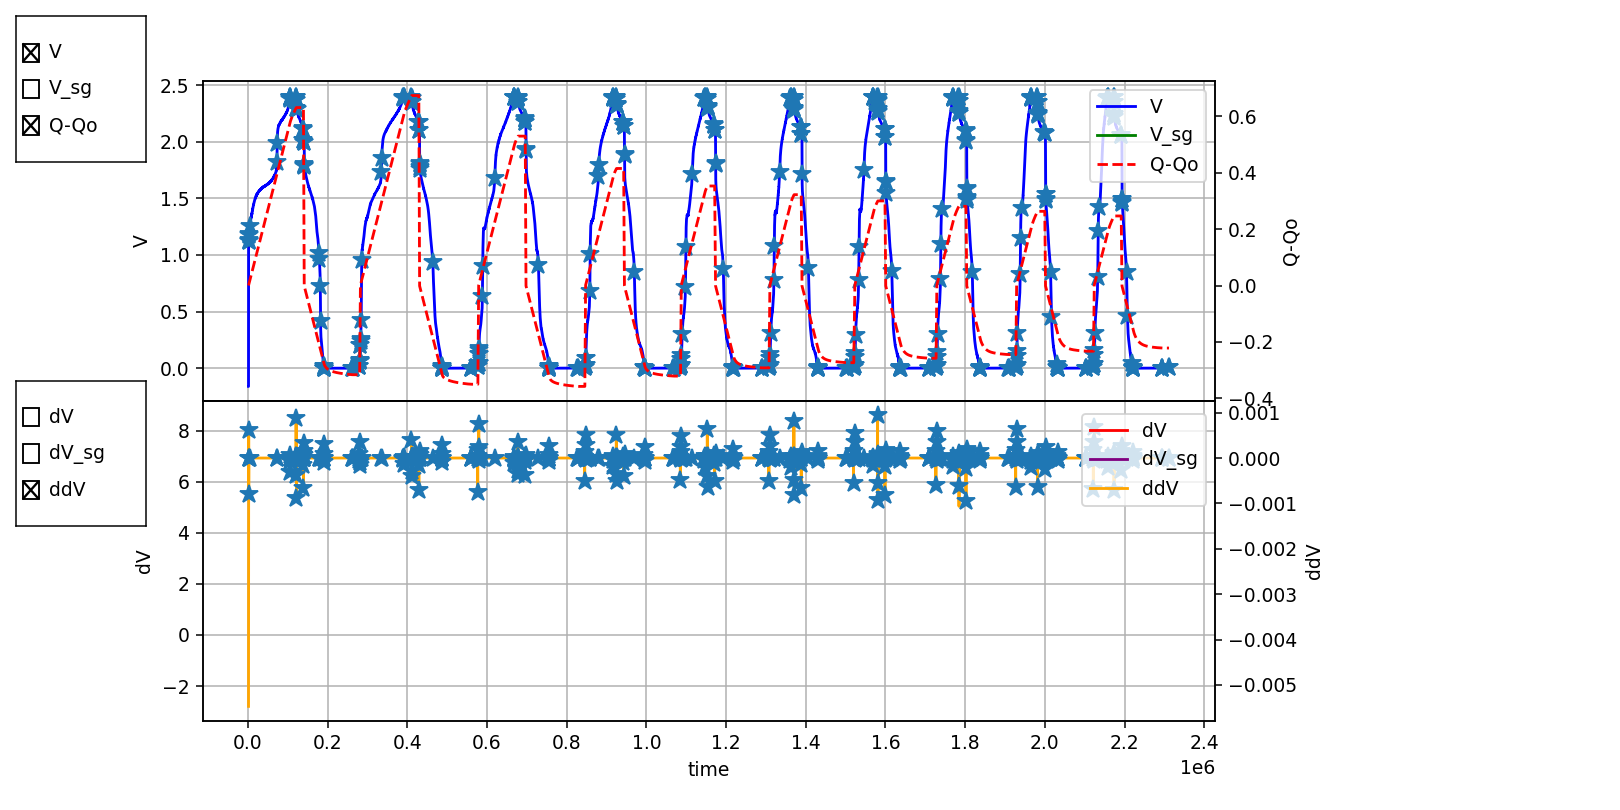

In [10]:
#plot the curves
%matplotlib notebook
## axis

fig,ax = plt.subplots(2,1,figsize=(12,6), sharex=True)
fig.subplots_adjust(right=0.75,top=0.9,hspace=.0)


ax[0].grid()
ax[1].grid()
ax1=ax[0].twinx()
ax2=ax[1].twinx()
ax[0].locator_params(axis='x', nbins=15)

#plot curves
p1,=ax[0].plot(t,V, color="blue", label='V',visible=True)
p1_sg,= ax[0].plot(t,V_sg, color="green", label='V_sg',visible=True)
q, = ax1.plot(t,Q, color="red",linestyle='--', label='Q-Qo',visible=True)
p2,=ax[1].plot(t,dV, color="red", label='dV',visible=True)
p2_sg,=ax[1].plot(t,dV_sg, color="purple", label='dV_sg',visible=True)
p3,=ax2.plot(t,ddV, color="orange", label='ddV',visible=True)


#plot points
invalid_point_index =np.argwhere(np.isnan([dV_sg[i] for i in point_index]))
point_index = np.delete(point_index, invalid_point_index)
# point_index = remove_trash_points(point_index,cell=cell,tech_type='form')#defined in next section
point_dV = ax[1].plot(t[point_index], [dV_sg[i] for i in point_index],'*',markersize=10,visible=True)
point_V = ax[0].plot(t[point_index], [V_sg[i] for i in point_index],'*',markersize=10,visible=True)
point_ddV = ax2.plot(t[point_index], [ddV[i] for i in point_index],'*',markersize=10,visible=True)

#set visible
fig.legend([p1,p1_sg,q],['V','V_sg','Q-Qo'],bbox_to_anchor=(0.75, 0.9))
fig.legend([p2,p2_sg,p3],['dV','dV_sg','ddV'],bbox_to_anchor=(0.75, 0.5))
p1_sg.set_visible(False)
p2.set_visible(False)
p2_sg.set_visible(False)
p3.set_visible(False)
point_dV[0].set_visible(False)
point_V[0].set_visible(True)
point_ddV[0].set_visible(False)

#x labels
ax[1].set_xlabel("time")
ax[0].set_ylabel("V")
ax1.set_ylabel("Q-Qo")
ax[1].set_ylabel("dV")
ax2.set_ylabel("ddV")


## define the checkboxes
ax_cb1 = plt.axes([0.01,0.8,0.08,0.18])
ax_cb2 = plt.axes([0.01,0.35,0.08,0.18])

## properties of checkboxes
cbs1 = CheckButtons(ax_cb1,['V','V_sg','Q-Qo'],actives=[True,False,True])
cbs2 = CheckButtons(ax_cb2,['dV','dV_sg','ddV'],actives=[False,False,False])
## updating function
def update(val):
    status1 = cbs1.get_status()
    status2 = cbs2.get_status()
    p1.set_visible(status1[0])
    p1_sg.set_visible(status1[1])
    q.set_visible(status1[2])
    p2.set_visible(status2[0])
    p2_sg.set_visible(status2[1])
    point_dV[0].set_visible(status2[1])
    point_ddV[0].set_visible(status2[2])
    p3.set_visible(status2[2])

    fig.canvas.draw()
    
cbs1.on_clicked(update)
cbs2.on_clicked(update)

plt.show()

## Cycling Phase

In [8]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db=np.unique([x.split('_')[0] for x in datafilespath])
v_dV_ddV_time=[]
for cell in db:
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)

    sql = 'SELECT `Ewe/V`,`time/s`,`half cycle`,`cycle_Nr` FROM ' +cell+ '.cyc_gcpl'
    cellx_df = pd.read_sql(sql, Connection)

    V = cellx_df['Ewe/V']
    #savgol_filter
    win_len = 179
    p_order = 3
    V_sg = savgol_filter(V,win_len,p_order)
    
    t =cellx_df['time/s']
    half_cycle = cellx_df['half cycle']
    cycle_Nr = cellx_df['cycle_Nr']
    
    #with savgol_filter
    dV_sg = np.divide(np.diff(V_sg,append=-1),np.diff(t,append=-1))
    #without savgpl_filter
    dV = np.divide(np.diff(V,append=-1),np.diff(t,append=-1))
    #2th derivative
    ddV = np.divide(np.diff(savgol_filter(dV_sg,win_len,p_order),append=-1),np.diff(t,append=-1))
    
    
    derivative_of_v_to_time = {'V':V,'V_sg':V_sg,'dV':dV,'dV_sg':dV_sg,'ddV':ddV,'t':t,'half cycle':half_cycle,'cycle_Nr':cycle_Nr}
    derivative_of_v_to_time = pd.DataFrame(data=derivative_of_v_to_time)    
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
    derivative_of_v_to_time.to_sql('derivative_of_v_to_time_cyc', engine, if_exists='replace',index=False,chunksize = 50000)
    print('table derivative_of_v_to_time of '+cell +' created')

table derivative_of_v_to_time of Cell001 created
table derivative_of_v_to_time of Cell002 created
table derivative_of_v_to_time of Cell003 created
table derivative_of_v_to_time of Cell004 created
table derivative_of_v_to_time of Cell005 created
table derivative_of_v_to_time of Cell006 created
table derivative_of_v_to_time of Cell007 created
table derivative_of_v_to_time of Cell008 created


In [123]:
# connection
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
cell='cell001'
Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)

# query from Mysql
sql = 'SELECT * FROM ' +cell+ '.derivative_of_v_to_time_cyc'
cellx_df = pd.read_sql(sql, Connection)
sql = 'SELECT `Q charge/discharge/mA.h` FROM ' +cell+ '.cyc_gcpl'
Q = pd.read_sql(sql, Connection)

print('data queried')
V = cellx_df['V'].copy()
V_sg = cellx_df['V_sg'].copy()
t = cellx_df['t'].copy()
dV = cellx_df['dV'].copy()
dV_sg = cellx_df['dV_sg'].copy()
ddV = cellx_df['ddV'].copy()
half_cycle = cellx_df['half cycle'].copy()
cycle_Nr = cellx_df['cycle_Nr'].copy()

data queried


In [124]:
def find_extreme_point_cyc(ddV,half_cycle,cycle_Nr):
    '''
    this func helps find all extreme points in the whole curve
    afterwards some should be filtered
    dV_sg should be continuous
    '''
    index=[]
    for cycle in np.unique(cycle_Nr):
        for soc in np.unique(half_cycle):
            tmp = ddV[(half_cycle==soc)&(cycle_Nr==cycle)].copy()#data of one cycle charge or discharge step
            num_peaks = find_peaks(tmp, prominence =0.0000001,height=-0.001,distance=50)
            if np.size(num_peaks[0])!=0:
                index = np.append(index,(num_peaks[0]+tmp.dropna().index[0]))
            tmp = -tmp# find negative peaks
            num_peaks = find_peaks(tmp, prominence =0.0000001,height=[None,0.001],distance=50) 
            if np.size(num_peaks[0])!=0:
                index = np.append(index,(num_peaks[0]+tmp.dropna().index[0]))
    return [int(i) for i in index]


def remove_EIS_cyc(dV,dV_sg,ddV):
    # in dV and ddV, remove the data in EIS phases

    ## get the time points of all eis processes
    sql = 'SELECT `time/s`,`cycle_Nr` FROM ' +cell+ '.cyc_geis'
    eis_time = pd.read_sql(sql, Connection)
    time=[]
    for cn in np.unique(eis_time['cycle_Nr']):
        start = eis_time.loc[eis_time['cycle_Nr']==cn]['time/s'].min()
        end = eis_time.loc[eis_time['cycle_Nr']==cn]['time/s'].max()
        time = np.append(time,[start,end])

    time=time.reshape((-1,2))

    ## in dV and ddV, replace with np.nan
    delta_t = 800
    for start,end in time:
        dV.loc[(t>start-3*delta_t)&(t<end+delta_t)] = np.nan
        dV_sg.loc[(t>start-3*delta_t)&(t<end+delta_t)] = np.nan
        ddV.loc[(t>start-3*delta_t)&(t<end+delta_t)] = np.nan
        
    return dV,dV_sg,ddV

In [125]:

ddV=remove_jumps(ddV,0.000005)
point_index = find_extreme_point_cyc(ddV,half_cycle,cycle_Nr)


<IPython.core.display.Javascript object>


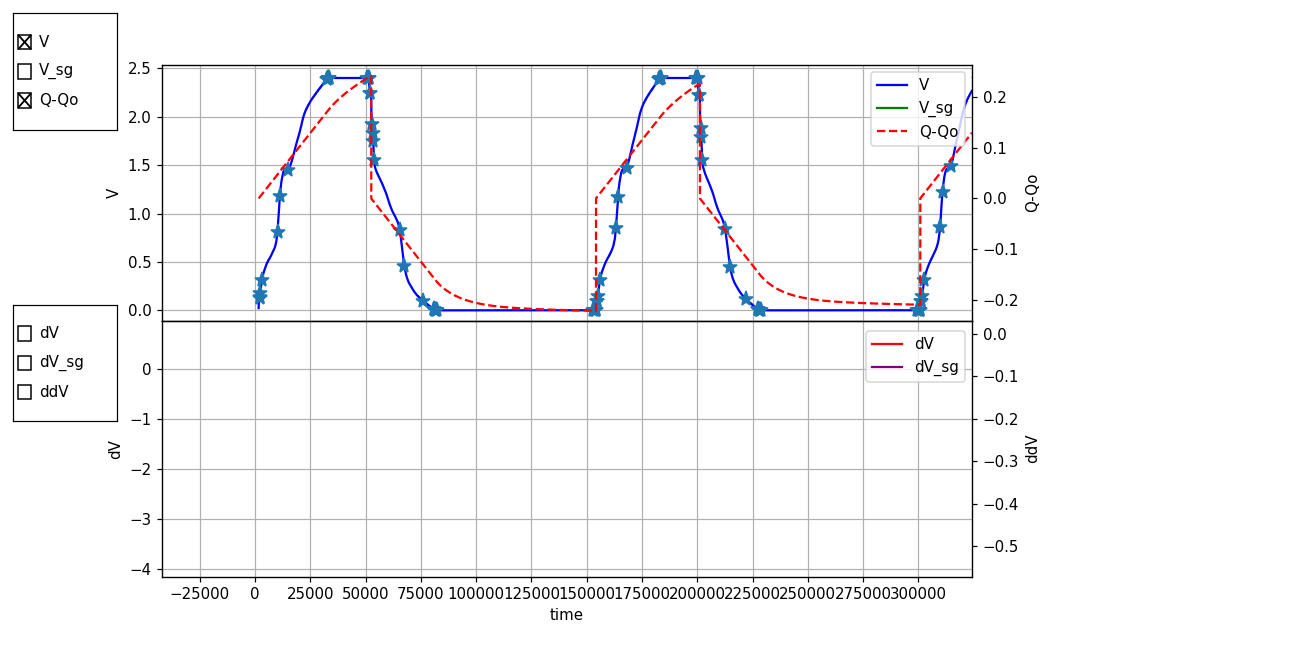

In [126]:
#plot the curves
%matplotlib notebook
## axis

fig,ax = plt.subplots(2,1,figsize=(12,6), sharex=True)
fig.subplots_adjust(right=0.75,top=0.9,hspace=.0)


ax[0].grid()
ax[1].grid()
ax1=ax[0].twinx()
ax2=ax[1].twinx()
ax[0].locator_params(axis='x', nbins=15)

#plot curves
p1,=ax[0].plot(t,V, color="blue", label='V',visible=True)
p1_sg,= ax[0].plot(t,V_sg, color="green", label='V_sg',visible=True)
q, = ax1.plot(t,Q, color="red",linestyle='--', label='Q-Qo',visible=True)
p2,=ax[1].plot(t,dV, color="red", label='dV',visible=True)
p2_sg,=ax[1].plot(t,dV_sg, color="purple", label='dV_sg',visible=True)
p3,=ax2.plot(t,ddV, color="orange", label='ddV',visible=True)

#plot points
invalid_point_index =np.argwhere(np.isnan([dV_sg[i] for i in point_index]))
point_index = np.delete(point_index, invalid_point_index)
# point_index = remove_trash_points(point_index,cell=cell,tech_type='cyc')#defined in next section
point_dV = ax[1].plot(t[point_index], [dV_sg[i] for i in point_index],'*',markersize=10,visible=True)
point_V = ax[0].plot(t[point_index], [V[i] for i in point_index],'*',markersize=10,visible=True)
point_ddV = ax2.plot(t[point_index], [ddV[i] for i in point_index],'*',markersize=10,visible=True)

#set visible
fig.legend([p1,p1_sg,q],['V','V_sg','Q-Qo'],bbox_to_anchor=(0.75, 0.9))
fig.legend([p2,p2_sg],['dV','dV_sg'],bbox_to_anchor=(0.75, 0.5))
p1_sg.set_visible(False)
p2.set_visible(False)
p2_sg.set_visible(False)
p3.set_visible(False)
point_dV[0].set_visible(False)
point_V[0].set_visible(True)
point_ddV[0].set_visible(False)

#x labels
ax[1].set_xlabel("time")
ax[0].set_ylabel("V")
ax1.set_ylabel("Q-Qo")
ax[1].set_ylabel("dV")
ax2.set_ylabel("ddV")


## define the checkboxes
ax_cb1 = plt.axes([0.01,0.8,0.08,0.18])
ax_cb2 = plt.axes([0.01,0.35,0.08,0.18])

## properties of checkboxes
cbs1 = CheckButtons(ax_cb1,['V','V_sg','Q-Qo'],actives=[True,False,True])
cbs2 = CheckButtons(ax_cb2,['dV','dV_sg','ddV'],actives=[False,False,False])
## updating function
def update(val):
    status1 = cbs1.get_status()
    status2 = cbs2.get_status()
    p1.set_visible(status1[0])
    p1_sg.set_visible(status1[1])
    q.set_visible(status1[2])
    p2.set_visible(status2[0])
    p2_sg.set_visible(status2[1])
    p3.set_visible(status2[2])
    point_dV[0].set_visible(status2[1])
    point_ddV[0].set_visible(status2[2])
    
    fig.canvas.draw()
    
cbs1.on_clicked(update)
cbs2.on_clicked(update)

plt.show()

## transfer points info to Mysql

### remove useless points

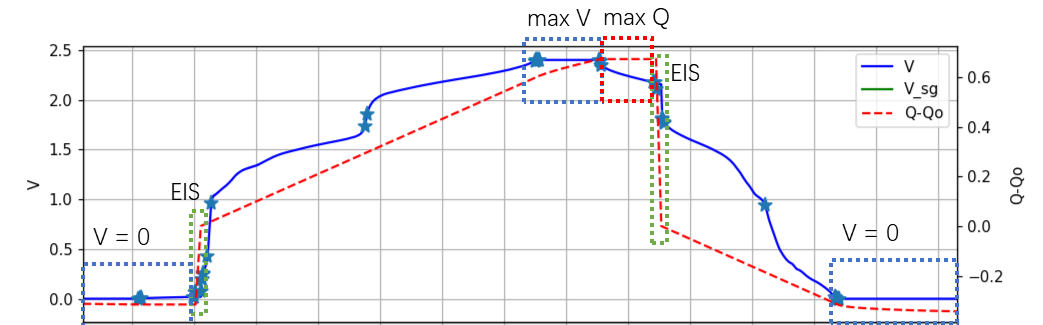



we need the tunning points to locate in:<br>
- charge: after Q=0 (beginning of charge) to before max V(2.39) 
- discharge: after Q=0 (beginning of discharge)to before V=0

In [120]:
def remove_trash_points(point_index,cell='cell001',tech_type='form'):
    if tech_type=='form':
        Q = '(Q-Qo)/mA.h'    
    elif tech_type=='cyc':
        Q = 'Q charge/discharge/mA.h'
    else: raise ValueError('no such technique step!')  
        
    sql = 'SELECT `{Q}`,`Ewe/V`,`half cycle`,`cycle_Nr` FROM {schema}.{tech_type}_gcpl'.format(Q=Q,schema=cell,tech_type=tech_type)
    
    cellx_df = pd.read_sql(sql, Connection)
    valid_index = []
    for cyc in np.unique(cellx_df['cycle_Nr']):
        charge_start = cellx_df[(cellx_df['cycle_Nr']==cyc)&(cellx_df['half cycle']==0)&(cellx_df[Q]>0.001)].index.min()
        charge_end = cellx_df[(cellx_df['cycle_Nr']==cyc)&(cellx_df['half cycle']==0)&(cellx_df['Ewe/V']>2.39)].index.min()
        discharge_start = cellx_df[(cellx_df['cycle_Nr']==cyc)&(cellx_df['half cycle']==1)&(cellx_df[Q]<-0.001)].index.min()
        discharge_end = cellx_df[(cellx_df['cycle_Nr']==cyc)&(cellx_df['half cycle']==1)&(cellx_df['Ewe/V']<0.01)].index.min()
        if np.nan in [charge_start,charge_end,discharge_start,discharge_end]:# in case the test not finished
            continue
        valid_index = np.append(valid_index,np.arange(charge_start,charge_end+1))
        valid_index = np.append(valid_index,np.arange(discharge_start,discharge_end+1))
    mask = np.isin(valid_index, point_index)    
    point_index = valid_index[mask]
    return point_index
            

### formation

In [17]:
#create a table of turning_points
# connection
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db=['cell001','cell002','cell003','cell004','cell005','cell006','cell007','cell008']

for cell in db:
    
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)

    # query from Mysql
    sql = 'SELECT * FROM ' +cell+ '.derivative_of_v_to_time_form'
    cellx_df = pd.read_sql(sql, Connection)
    sql = 'SELECT `(Q-Qo)/mA.h` FROM ' +cell+ '.form_gcpl'
    Q = pd.read_sql(sql, Connection)
    Q = Q['(Q-Qo)/mA.h'].copy()

    
    print('{} data queried'.format(cell))
    V = cellx_df['V'].copy()
    V_sg = cellx_df['V_sg'].copy()
    t = cellx_df['t'].copy()
    dV = cellx_df['dV'].copy()
    dV_sg = cellx_df['dV_sg'].copy()
    ddV = cellx_df['ddV'].copy()
    half_cycle = cellx_df['half cycle'].copy()
    loop_Nr = cellx_df['loop_Nr'].copy()
    
    # find the points and filter them
    
#     dV=remove_jumps(dV,0.001)
#     dV_sg=remove_jumps(dV_sg,0.001)
    ddV=remove_jumps(ddV,0.001)
    point_index = find_extreme_point(ddV,half_cycle,loop_Nr)
    point_index = remove_trash_points(point_index,cell=cell,tech_type='form')
#     dV,dV_sg,ddV = remove_constant_V(dV,dV_sg,ddV)
#     dV,dV_sg,ddV = remove_EIS(dV,dV_sg,ddV)
    invalid_point_index =np.argwhere(np.isnan([dV_sg[i] for i in point_index]))
    point_index = np.delete(point_index, invalid_point_index)
    
    points = {'t':t[point_index].values,'V':V[point_index].values,'Q':Q[point_index].values,
              'half cycle':half_cycle[point_index].values,'loop_Nr':loop_Nr[point_index].values}
    points = pd.DataFrame(data=points)
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
    points.to_sql('turning_points_form', engine, if_exists='replace',index=False,chunksize = 50000)
    print('table research_points of '+cell +' created')



cell001 data queried
table research_points of cell001 created
cell002 data queried
table research_points of cell002 created
cell003 data queried
table research_points of cell003 created
cell004 data queried
table research_points of cell004 created
cell005 data queried
table research_points of cell005 created
cell006 data queried
table research_points of cell006 created
cell007 data queried
table research_points of cell007 created
cell008 data queried
table research_points of cell008 created


### cycling

In [18]:
#create a table of turning_points
# connection
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db=['cell001','cell002','cell003','cell004','cell005','cell006','cell007','cell008']

for cell in db:
    
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)

    # query from Mysql
    sql = 'SELECT * FROM ' +cell+ '.derivative_of_v_to_time_cyc'
    cellx_df = pd.read_sql(sql, Connection)
    sql = 'SELECT `Q charge/discharge/mA.h` FROM ' +cell+ '.cyc_gcpl'
    Q = pd.read_sql(sql, Connection)
    Q = Q['Q charge/discharge/mA.h'].copy()
    
    print('{} data queried'.format(cell))
    V = cellx_df['V'].copy()
    V_sg = cellx_df['V_sg'].copy()
    t = cellx_df['t'].copy()
    dV = cellx_df['dV'].copy()
    dV_sg = cellx_df['dV_sg'].copy()
    ddV = cellx_df['ddV'].copy()
    half_cycle = cellx_df['half cycle'].copy()
    cycle_Nr = cellx_df['cycle_Nr'].copy()
    
    # find the points and filter them
#     dV=remove_jumps(dV,0.001)
#     dV_sg=remove_jumps(dV_sg,0.001)
    ddV=remove_jumps(ddV,0.000005)
    point_index = find_extreme_point_cyc(ddV,half_cycle,cycle_Nr)
    point_index = remove_trash_points(point_index,cell=cell,tech_type='cyc')
#     dV,dV_sg,ddV = remove_constant_V(dV,dV_sg,ddV)
#     dV,dV_sg,ddV = remove_EIS_cyc(dV,dV_sg,ddV)
    
    invalid_point_index =np.argwhere(np.isnan([dV_sg[i] for i in point_index]))
    point_index = np.delete(point_index, invalid_point_index)
    
    points = {'t':t[point_index].values,'V':V[point_index].values,'Q':Q[point_index].values,
              'half cycle':half_cycle[point_index].values,'cycle_Nr':cycle_Nr[point_index].values }
    points = pd.DataFrame(data=points)
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
    points.to_sql('turning_points_cyc', engine, if_exists='replace',index=False,chunksize = 50000)
    print('table research_points of '+cell +' created')



cell001 data queried
table research_points of cell001 created
cell002 data queried
table research_points of cell002 created
cell003 data queried
table research_points of cell003 created
cell004 data queried
table research_points of cell004 created
cell005 data queried
table research_points of cell005 created
cell006 data queried
table research_points of cell006 created
cell007 data queried
table research_points of cell007 created
cell008 data queried
table research_points of cell008 created


# Voltage and Electric Charge

## $V$ vs. Q

## clustering

D:\Study\Software\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


<IPython.core.display.Javascript object>


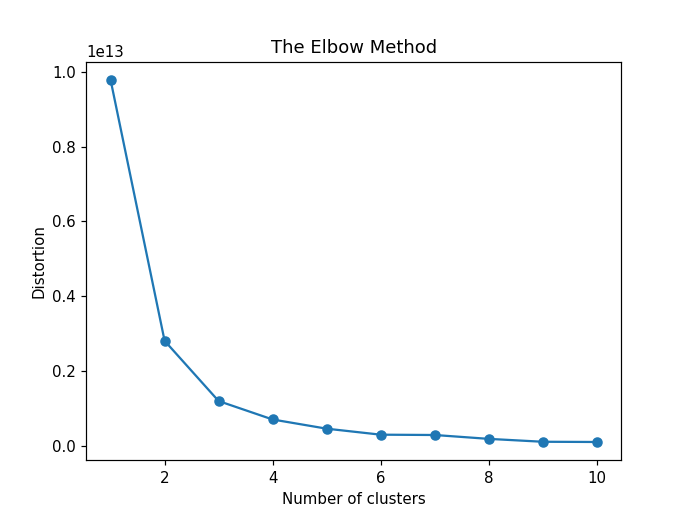

In [115]:
#The Elbow Method
distortions = []
Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)
#add new column
cursor=Connection.cursor()
sql = 'SELECT * FROM turning_points_form'
tp_df = pd.read_sql(sql, Connection)
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(tp_df)
    distortions.append(km.inertia_)

# plot
plt.figure()
plt.plot(range(1, 11), distortions, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [21]:
# connection
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db=['cell001','cell002','cell003','cell004','cell005','cell006','cell007','cell008']

for cell in db:
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)

    for tech_type in ['form', 'cyc']:
        #add new column
        cursor=Connection.cursor()
        try: 
            cursor.execute('ALTER TABLE turning_points_{} ADD cluster_label INT'.format(tech_type))
        except:
            print('column cluster_label already created')
        # query data
        sql = 'SELECT * FROM turning_points_{}'.format(tech_type)
        tp_df = pd.read_sql(sql, Connection)
        tp_posi = tp_df[tp_df['Q']>0].copy()
        tp_nega = tp_df[tp_df['Q']<0].copy()
        #kmeans
        km_posi = KMeans(n_clusters=3, init='random', random_state=0)
        y_km_posi = km_posi.fit_predict(tp_posi[['Q','V']])
        tp_posi['cluster_label'] = km_posi.labels_
        km_nega = KMeans(n_clusters=3, init='random', random_state=0)
        y_km_nega = km_nega.fit_predict(tp_nega[['Q','V']]) 
        tp_nega['cluster_label'] = km_nega.labels_
        tp = pd.concat([tp_posi, tp_nega], axis=0)
        #write labels to mysql
        #drop the table first. Weird, when if_exists='replace', the function not working
        cursor.execute('DROP TABLE turning_points_{}'.format(tech_type))
        engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
        tp.to_sql('turning_points_{}'.format(tech_type), engine, if_exists='fail',index=False)
        print('cluster_label in table turning_points_{tech_type} of {cell} added'.format(tech_type=tech_type,cell=cell) )
    
    Connection.close()

cluster_label in table turning_points_form of cell001 added
cluster_label in table turning_points_cyc of cell001 added
cluster_label in table turning_points_form of cell002 added
cluster_label in table turning_points_cyc of cell002 added
cluster_label in table turning_points_form of cell003 added
cluster_label in table turning_points_cyc of cell003 added
cluster_label in table turning_points_form of cell004 added
cluster_label in table turning_points_cyc of cell004 added
cluster_label in table turning_points_form of cell005 added
cluster_label in table turning_points_cyc of cell005 added
cluster_label in table turning_points_form of cell006 added
cluster_label in table turning_points_cyc of cell006 added
cluster_label in table turning_points_form of cell007 added
cluster_label in table turning_points_cyc of cell007 added
cluster_label in table turning_points_form of cell008 added
cluster_label in table turning_points_cyc of cell008 added


### formation

<IPython.core.display.Javascript object>


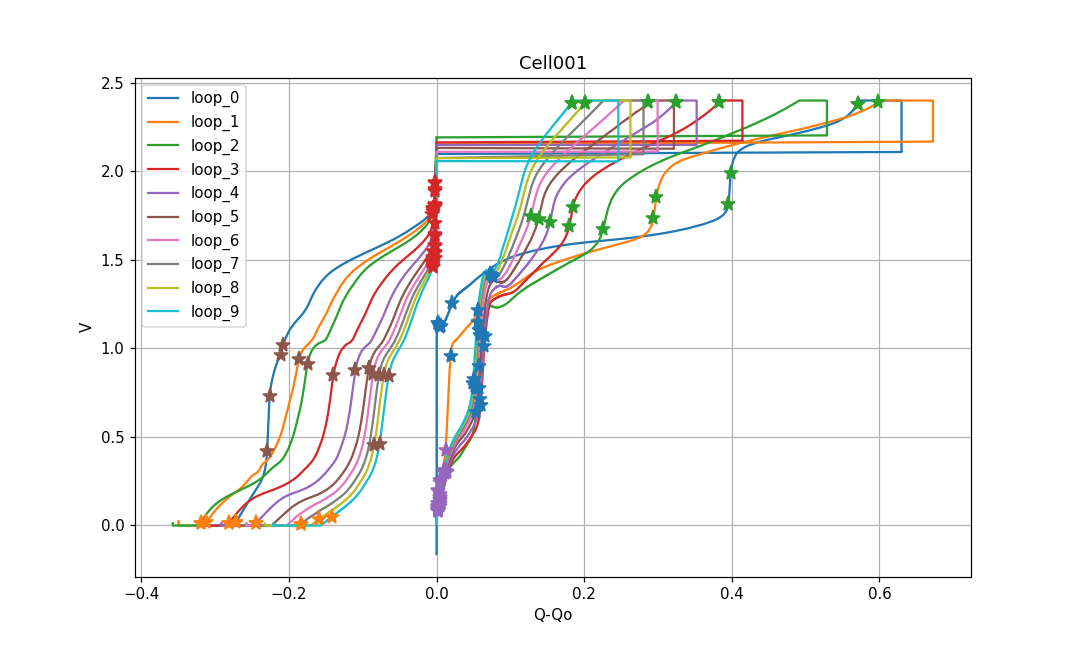

In [128]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
cell='Cell001'
Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)

sql = 'SELECT `Ewe/V`,`(Q-Qo)/mA.h`,`loop_Nr`,`time/s` FROM form_gcpl'
cellx_df = pd.read_sql(sql, Connection)

V = cellx_df['Ewe/V']
loop = cellx_df['loop_Nr']
t = cellx_df['time/s']
Q =cellx_df['(Q-Qo)/mA.h']

sql = 'SELECT `t`,`V`,`Q`,`half cycle`,`cluster_label` FROM turning_points_form'
tp_df = pd.read_sql(sql, Connection)

fig,ax = plt.subplots(figsize=(10,6))
plt.title(cell)
l = ax.plot(
    Q[loop==0],V[loop==0],
    Q[loop==1],V[loop==1],
    Q[loop==2],V[loop==2],
    Q[loop==3],V[loop==3],
    Q[loop==4],V[loop==4],
    Q[loop==5],V[loop==5],
    Q[loop==6],V[loop==6],
    Q[loop==7],V[loop==7],
    Q[loop==8],V[loop==8],
    Q[loop==9],V[loop==9]
       )
ax.legend(['loop_0','loop_1','loop_2','loop_3','loop_4','loop_5','loop_6','loop_7','loop_8','loop_9'])
ax.set_xlabel("Q-Qo")
ax.set_ylabel("V")

cluster = np.unique(tp_df['cluster_label'])
for clu in cluster:
    for hc in [0,1]:
        point_Q = ax.plot( tp_df[(tp_df['cluster_label']==clu)&(tp_df['half cycle']==hc)]['Q'],
                          tp_df[(tp_df['cluster_label']==clu)&(tp_df['half cycle']==hc)]['V'],
                          '*',markersize=10,visible=True)
ax.grid()
# ## define the checkboxes
# ax_cb = plt.axes([0.7,0.2,0.2,0.4])
# cbs = CheckButtons(ax_cb,['loop_0','loop_1','loop_2','loop_3','loop_4','loop_5','loop_6','loop_7','loop_8','loop_9'],
#                     actives=[True,True,True,True,True,True,True,True,True,True])

# ## updating function
# def update(val):
#     status = cbs.get_status()
#     l[0].set_visible(status[0])
#     l[1].set_visible(status[1])
#     l[2].set_visible(status[2])
#     l[3].set_visible(status[3])
#     l[4].set_visible(status[4])
#     l[5].set_visible(status[5])
#     l[6].set_visible(status[6])
#     l[7].set_visible(status[7])
#     l[8].set_visible(status[8])
#     l[9].set_visible(status[9])
#     fig.canvas.draw()
# cbs.on_clicked(update)


plt.show()

### cycling

<IPython.core.display.Javascript object>


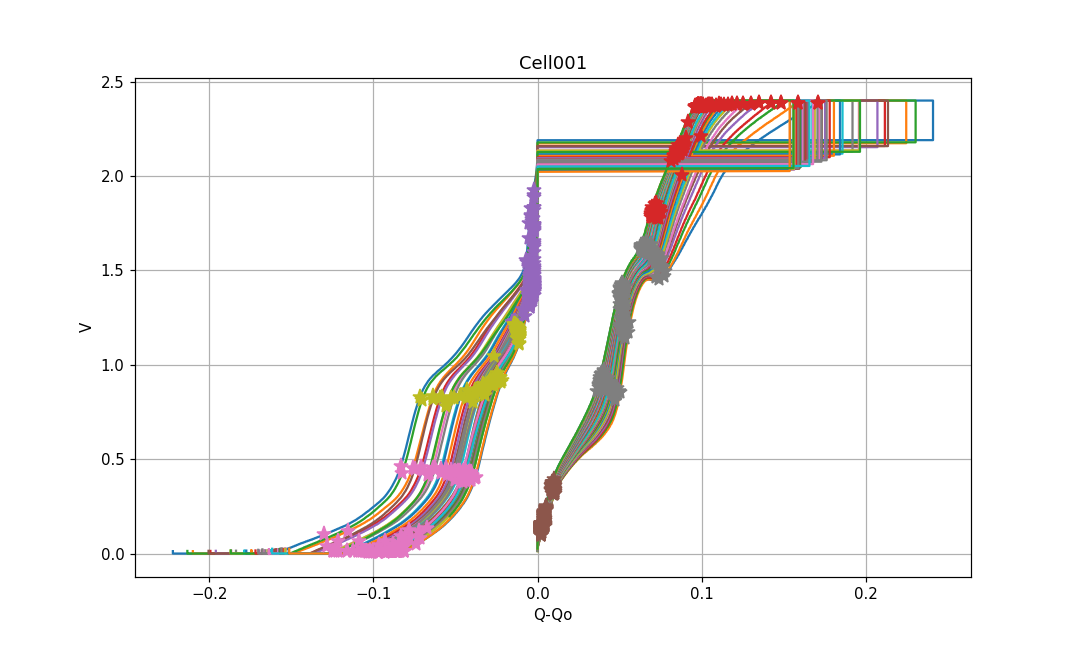

In [130]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
cell='Cell001'
Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)

sql = 'SELECT `Ewe/V`,`Q charge/discharge/mA.h`,`cycle_Nr`,`time/s` FROM cyc_gcpl'
cellx_df = pd.read_sql(sql, Connection)

V = cellx_df['Ewe/V'].copy()
cycle = cellx_df['cycle_Nr'].copy()
t = cellx_df['time/s'].copy()
Q =cellx_df['Q charge/discharge/mA.h'].copy()

sql = 'SELECT `t`,`V`,`Q`,`half cycle`,`cluster_label` FROM turning_points_cyc'
tp_df = pd.read_sql(sql, Connection)
fig,ax = plt.subplots(figsize=(10,6))
plt.title(cell)
[ax.plot(Q[cycle==i],V[cycle==i]) for i in np.unique(cycle)]
ax.set_xlabel("Q-Qo")
ax.set_ylabel("V")
for clu in cluster:
    for hc in [0,1]:
        point_Q = ax.plot( tp_df[(tp_df['cluster_label']==clu)&(tp_df['half cycle']==hc)]['Q'],
                          tp_df[(tp_df['cluster_label']==clu)&(tp_df['half cycle']==hc)]['V'],
                          '*',markersize=10,visible=True)
# ## define the checkboxes
# ax_cb = plt.axes([0.75,0.2,0.15,0.1])
# cbs = CheckButtons(ax_cb,labels =['turning points'],actives=[True])
ax.grid()

# def update(val):
#     status = cbs.get_status()
#     point_Q[0].set_visible(status[0])
#     fig.canvas.draw()
# cbs.on_clicked(update)

plt.show()

## Q vs. $V$

# EIS

## formation

<IPython.core.display.Javascript object>


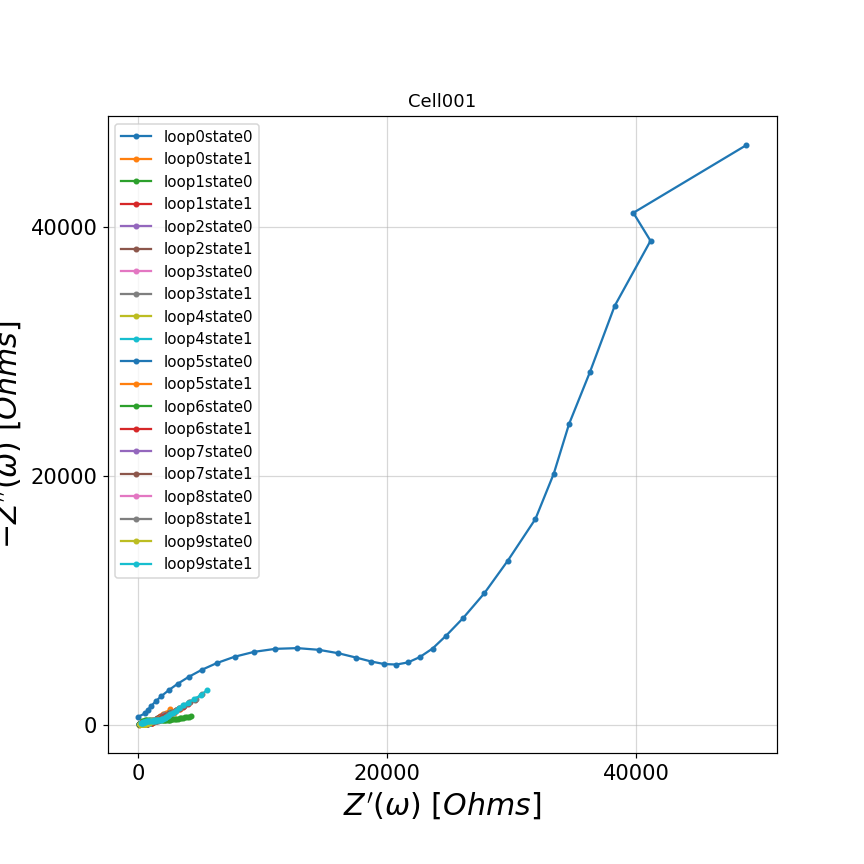

In [25]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
cell='Cell001'
Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)

sql = 'SELECT `freq/Hz`,`Re(Z)/Ohm`,`-Im(Z)/Ohm`,`loop_Nr`,`state of charge` FROM ' +cell+ '.form_geis'
cellx_df = pd.read_sql(sql, Connection)
fig, ax = plt.subplots(figsize=(8,8))
plt.title(cell)
Legend = []
for i in np.unique(cellx_df['loop_Nr']):
    for j in np.unique(cellx_df['state of charge']):
        f = np.array(cellx_df[(cellx_df['loop_Nr']==i) & (cellx_df['state of charge']==j)]['freq/Hz'])
        Z = np.array(cellx_df[(cellx_df['loop_Nr']==i) & (cellx_df['state of charge']==j)][['Re(Z)/Ohm','-Im(Z)/Ohm']])
        Z = Z[:, 0] - 1j*Z[:, 1]
        f, Z = preprocessing.ignoreBelowX(f, Z)
        plot_nyquist(ax, Z)
        Legend = np.append(Legend,'loop'+str(i)+'state'+str(j))
ax.legend(Legend)
plt.show()



<IPython.core.display.Javascript object>


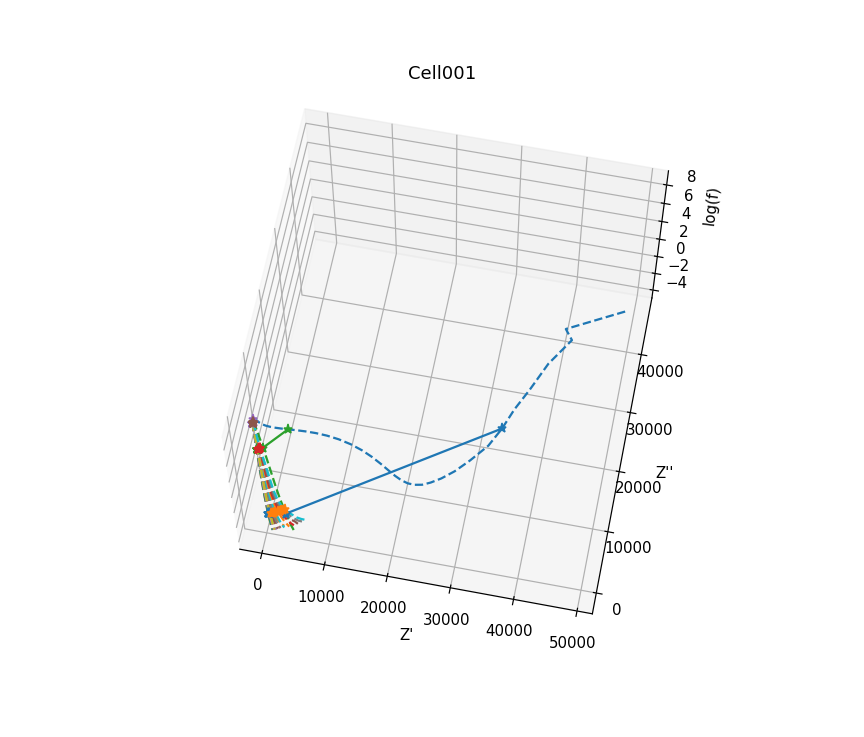

In [136]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
cell='Cell001'
Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)

sql = 'SELECT `freq/Hz`,`Re(Z)/Ohm`,`-Im(Z)/Ohm`,`loop_Nr`,`state of charge` FROM ' +cell+ '.form_geis'
cellx_df = pd.read_sql(sql, Connection)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
plt.title(cell)
Legend = []
[low,medium,high]=[0.107102,425.149,10001]
for i in np.unique(cellx_df['loop_Nr']):
    for j in np.unique(cellx_df['state of charge']):
        f = np.array(cellx_df[(cellx_df['loop_Nr']==i) & (cellx_df['state of charge']==j)]['freq/Hz'])
        Z = np.array(cellx_df[(cellx_df['loop_Nr']==i) & (cellx_df['state of charge']==j)][['Re(Z)/Ohm','-Im(Z)/Ohm']])
        ax.plot3D( Z[:, 0] ,Z[:, 1],np.log(f),'--');
        Legend = np.append(Legend,'loop'+str(i)+'state'+str(j))
for freq in [low,medium,high]:
    for j in np.unique(cellx_df['state of charge']):
        ax.plot3D(cellx_df[(cellx_df['freq/Hz']==freq) & (cellx_df['state of charge']==j)]['Re(Z)/Ohm'],
                  cellx_df[(cellx_df['freq/Hz']==freq) & (cellx_df['state of charge']==j)]['-Im(Z)/Ohm'],
                  np.log(cellx_df[(cellx_df['freq/Hz']==freq) & (cellx_df['state of charge']==j)]['freq/Hz']),marker='*')
ax.set_xlabel("Z'")
ax.set_ylabel("Z''")
ax.set_zlabel('log(f)')
# ax.legend(Legend)
plt.show()

## cycling

<IPython.core.display.Javascript object>


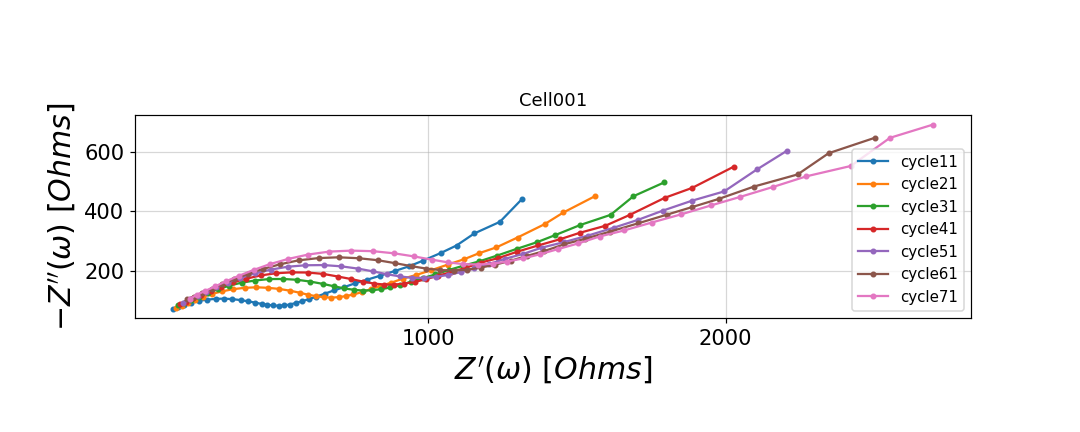

In [28]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
cell='Cell001'
Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)

sql = 'SELECT `freq/Hz`,`Re(Z)/Ohm`,`-Im(Z)/Ohm`,`cycle_Nr` FROM ' +cell+ '.cyc_geis'
cellx_df = pd.read_sql(sql, Connection)

fig, ax = plt.subplots(figsize=(10,4))
plt.title(cell)
Legend = []
for i in np.unique(cellx_df['cycle_Nr']):
    f = np.array(cellx_df[(cellx_df['cycle_Nr']==i)]['freq/Hz'])
    Z = np.array(cellx_df[(cellx_df['cycle_Nr']==i)][['Re(Z)/Ohm','-Im(Z)/Ohm']])
    Z = Z[:, 0] - 1j*Z[:, 1]
    f, Z = preprocessing.ignoreBelowX(f, Z)
    plot_nyquist(ax, Z)
    Legend = np.append(Legend,'cycle'+str(i))
ax.legend(Legend)
plt.show()

<IPython.core.display.Javascript object>


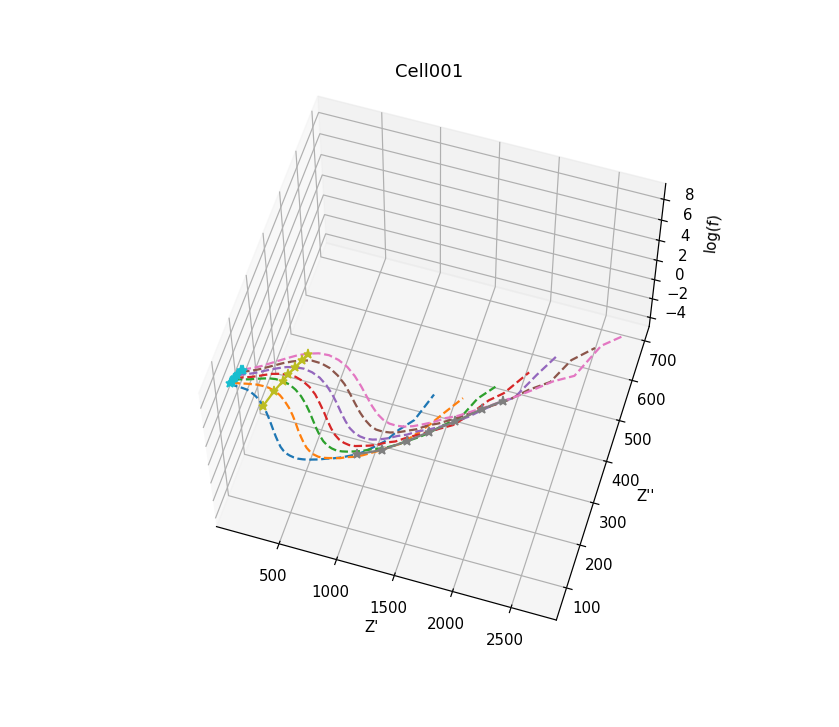

In [137]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
cell='Cell001'
Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)

sql = 'SELECT `freq/Hz`,`Re(Z)/Ohm`,`-Im(Z)/Ohm`,`cycle_Nr` FROM ' +cell+ '.cyc_geis'
cellx_df = pd.read_sql(sql, Connection)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
plt.title(cell)
Legend = []
for i in np.unique(cellx_df['cycle_Nr']):
    f = np.array(cellx_df[(cellx_df['cycle_Nr']==i)]['freq/Hz'])
    Z = np.array(cellx_df[(cellx_df['cycle_Nr']==i)][['Re(Z)/Ohm','-Im(Z)/Ohm']])
#     ax.scatter3D( Z[:, 0] ,Z[:, 1],np.log(f))
    ax.plot3D(Z[:, 0] ,Z[:, 1],np.log(f),'--')
[low,medium,high]=[0.107102,425.149,10001]
for freq in [low,medium,high]:
    ax.plot3D(cellx_df[cellx_df['freq/Hz']==freq]['Re(Z)/Ohm'],
              cellx_df[cellx_df['freq/Hz']==freq]['-Im(Z)/Ohm'],
              np.log(cellx_df[cellx_df['freq/Hz']==freq]['freq/Hz']),marker='*')

ax.set_xlabel("Z'")
ax.set_ylabel("Z''")
ax.set_zlabel('log(f)')
plt.show()

## extract EIS data by low, medium and high frequency
use to represent the feutures in different f   
low = 0.107102Hz;    
medium = 425.149Hz;    
high = 10001Hz;

In [30]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
cell='Cell001'
cells = ['cell001','cell002','cell003','cell004','cell005','cell006','cell007','cell008']
low = 0.107102
medium = 425.149
high = 10001
for cell in cells:
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)

    sql = 'SELECT `freq/Hz`,`Re(Z)/Ohm`,`-Im(Z)/Ohm`,`loop_Nr`,`state of charge` FROM ' +cell+ '.form_geis'
    cellx_df_form = pd.read_sql(sql, Connection)
    sql = 'SELECT `freq/Hz`,`Re(Z)/Ohm`,`-Im(Z)/Ohm`,`cycle_Nr` FROM ' +cell+ '.cyc_geis'
    cellx_df_cyc = pd.read_sql(sql, Connection)   
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
    eis_form = cellx_df_form[cellx_df_form['freq/Hz'].isin([low,medium,high])].sort_values(['freq/Hz','loop_Nr','state of charge'])
    eis_cyc = cellx_df_cyc[cellx_df_cyc['freq/Hz'].isin([low,medium,high])].sort_values(['freq/Hz','cycle_Nr'])
    eis_form.to_sql('eis_feature_form', engine, if_exists='replace',index=False)
    eis_cyc.to_sql('eis_feature_cyc', engine, if_exists='replace',index=False)
    print('eis features of {cell} extrated'.format(cell=cell))

eis features of cell001 extrated
eis features of cell002 extrated
eis features of cell003 extrated
eis features of cell004 extrated
eis features of cell005 extrated
eis features of cell006 extrated
eis features of cell007 extrated
eis features of cell008 extrated
